#### Sky background subtraction and aperture photometry

In this lecture, we will see how to compute and subtract the local sky background 
around the star under analysis, and then we will check how to determine a proper aperture to measure the flux of the star



In [27]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import pickle
from astropy.io import fits 
%matplotlib widget 

In [48]:
science_list = np.genfromtxt('science/science.list', dtype=str)
#Здесь используется функция np.genfromtxt из библиотеки NumPy для загрузки данных из 
# текстового файла 'science.list'
# Параметр dtype=str означает, что данные будут загружены в виде строк 
# В результате science_list становится массивом строк, содержащим имена или пути файлов

science_temp_list = science_list[:10]
#создается подмассив science_temp_list, который содержит первые 10 элементов из science_list
#science_frame_name = 'correct' + science_test_list[-1][:-5] + '.p'
#science_corrected = pickle.load(open(science_frame_name, 'rb'))

#print(science_temp_list)
#print(science_temp_list[5][:-5])


science_corrected = pickle.load(open('./correct/' + science_temp_list[-1][:-5] + '_corr.p', 'rb'))
# science_temp_list[5][:-5] берет шестой элемент (science_temp_list[5]) из временного списка science_temp_list
# Использует срез [:-5] для удаления последних пяти символов из этой строки.  
# делается для получения базового имени файла без расширения.
# Загружает файл с расширением '_corr.p' с использованием модуля pickle, 
# (который используется для сериализации и десериализации объектов Python)
# Этот файл находится в директории '/correct/'
# Режим 'rb' -- файл открывается в двоичном формате для чтения

science_corrected_err = pickle.load(open('./correct/' + science_temp_list[-1][:-5] + '_corr_errors.p', 'rb'))

In [49]:
#x_target_refined = 92.59
#y_target_refined = 64.25 ?

x_target_refined = 92.61
y_target_refined = 64.27

# Computing again the meshgrid arrays 
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

# 2D array with the distance of each pixel from the target star 
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)

In [46]:
def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    # define a function to plot a circle on the desired coordinates 
    # x_pos, ypos with radius radius [all in pixel units]
    # Optional arguments: 
    # thickness: the thickness of the circle expressed in pixel
    # label: the label associated with the circle (default label='', which means no label), 
    # color: the colour of the circle in matplotlib standard named colours (default color='w', i.e., white circle), 
    # alpha: transparency of the circle (default alpha=1., where alpha can go from 0 from a completely transparent circle to 1. for a full circle)

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)


#### Computation of the sky background

Методику определения средней яркости фонового неба вокруг звезды с использованием кольца или аннулуса
Методика помогает более точно оценить средний уровень фонового неба вокруг звезды, минимизируя вклад света от самой звезды и других объектов

1. **Проблема с фоновым небом:**
   - Трудно найти участок на изображении, который не содержит звезды или других объектов и где уровень фонового неба постоянен. Чтобы справиться с этой проблемой, предлагается измерять фон в кольце вокруг звезды.
   
   To compute the average sky background around our star, we need to define a region of the sensor void of stars or other contaminants. In principle, we could select any region of the frame with these characteristics. However, we should ensure that the sky background level is constant across the frame, which is problematic. A more accessible but still effective approach is to measure the sky background level in a ring, or annulus, around our target. If we centre this annulus on the centroid position of our target, we only need to define its inner radius and outer radius to define it.

2. **Использование аннулуса:**
   - **Annulus** — это кольцо на изображении, которое размещается вокруг звезды. Его центр совпадает с центроидом звезды, а границы определяются двумя радиусами: внутренним и внешним.

3. **Внутренний радиус:**
   - Этот радиус должен быть достаточнo большим, чтобы полностью включить звезду и предотвратить попадание её света в кольцо для измерения фонового неба. Он должен быть установлен так, чтобы исключить свет от звезды
   
   **Inner radius** Since we want to measure the sky background flux, we must be sure that the selected pixels do not contain any flux coming from the target. In other words, the inner radius must be large enough to include our star completely, and eventually include some background. In the previous lecture, we defined a radius, called inner_radius, to select the pixels over which to compute the centroid position of the target star. We can still use this radius if we selected this radius by excluding the star's flux completely, as already anticipated during the previous notebook

4. **Внешний радиус:**
   - Внешний радиус должен быть выбран так, чтобы свет от соседних объектов не попадал в аннулус, при этом важно, чтобы в кольце было достаточно пикселей для надежного статистического анализа яркости фонового неба

   **Outer radius** The outer radius can be as large as you want, but you must be sure that no light from nearby targets enters the annulus. The outer radius should be large enough so that the annulus will include a sufficient number of pixels to determine the average (or median) sky background robustly.

5. **Практическая реализация:**
   - Для проверки корректности выбора радиусов, предлагается визуализировать часть изображения, включая звезду, с использованием пониженного значения для `vmax` (максимальной видимой яркости пикселей), чтобы лучше выделить распределение потока на краях звезды. Это помогает увидеть, как свет от звезды соотносится с уровнем фонового неба
   
   To ensure that our selection of the inner_radius and outer_radius satisfy these requirements, we can plot the portion of the frame including our target with a lower value for vmax, e.g., using just as twice the vmin value, together with two circles representing the inner and outer radii. By doing so, we lose information on the flux distribution near the centre of the star - as all the pixels with flix higher than vmax will have the same colour - but we highlight the flux distribution on the wings of the star where the flux coming from the star is comparable with the sky background.



vmin:  531.8    vmax: 1063.7


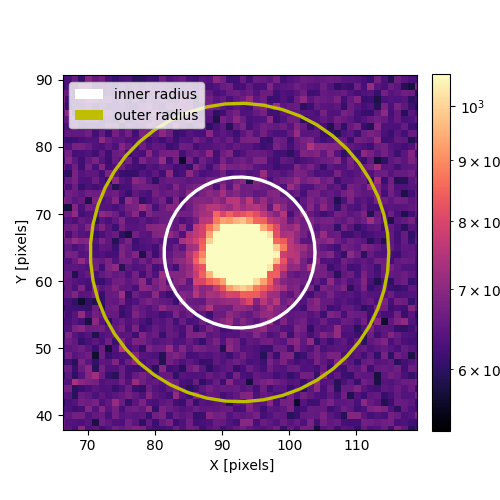

In [57]:
# Value for the inner radius
inner_radius = 11
outer_radius = 22
    
from matplotlib import colors 

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
vmax = vmin*2
# vmin устанавливается как минимальное значение внутри выбранного диапазона колонок (100 до 400) 
# массива science_corrected
# vmax первоначально устанавливается как максимальное значение в том же диапазоне, 
# но затем переопределяется как 2*vmin. Это делается, чтобы уменьшить диапазон значений для 
# отображения, что может помочь лучше визуализировать слабые сигналы в изображении


print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
#Печатается минимальное и максимальное значения для контроля пользователя

fig, ax = plt.subplots(1, figsize=(5,5))
# Создается фигура с одной осью размерами 5x5 дюймов

im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], 
                 norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
# Изображение science_corrected отображается с использованием цветовой палитры "magma".
# Масштабирование по яркости применяется с помощью логарифмической нормировки 
# LogNorm, что позволяет лучше различать изменения в данных при существовании 
# большого диапазона значений

plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)
# Добавляется цветовая панель к изображению для интерпретации цветов в терминах количественных значений.


# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target_refined-outer_radius*1.2, x_target_refined+outer_radius*1.2)
plt.ylim(y_target_refined-outer_radius*1.2, y_target_refined+outer_radius*1.2)
# Ограничивается область отображения до указанного диапазона вокруг целевой звезды с 
# учетом некоторых запасов, зависящих от outer_radius

make_circle_around_star(x_target_refined, y_target_refined, inner_radius, label='inner radius')
make_circle_around_star(x_target_refined, y_target_refined, outer_radius, color='y', label='outer radius')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()

To compute the **sky background**, we select the pixel within distance from the target target_distance between inner_radius and outer_radius

The array annulus_selection is a Boolean array 
The shape of it the same as scientific frame, 
where every pixel will be True if it inside annulus and False otherwise

Since Python interprets True as 1.0 and False as 0.0 when converting from Boolean to Real, summing over annulus_selection will give the number of pixels satisfying the condition. Be sure that this value is higher than 150, to compute the mean and/or the median over a statistically significant sample size of pixels.

The average (or median) over the selected pixels gives the average sky background per pixel
________________

Описывает методику вычисления среднего уровня фонового неба на изображении, используя кольцо или аннулус вокруг целевой звезды:

1. **Выбор пикселей:** 
   - Для вычисления фонового неба выбираются пиксели, находящиеся на определенном расстоянии от целевой звезды. Это расстояние ограничено двумя радиусами: `inner_radius` и `outer_radius`, определяющими внутреннюю и внешнюю границы кольца.

2. **Логический массив:** 
   - Создается логический массив `annulus_selection`, который имеет ту же размерность, что и научное изображение. В этом массиве каждое значение будет `True`, если соответствующий пиксель находится в пределах аннулуса, и `False`, если нет.

3. **Подсчет пикселей:** 
   - Поскольку Python интерпретирует `True` как 1.0 и `False` как 0.0 при преобразовании в числа с плавающей запятой, сумма значений в `annulus_selection` даст количество пикселей, подходящих под критерии (находящихся в кольце).

4. **Требование к количеству пикселей:**
   - Убедитесь, что количество пикселей, удовлетворяющих условию, превышает 150. Это необходимо для обеспечения статистически значимой выборки, чтобы можно было надежно вычислить среднее или медианное значение фонового неба.

5. **Построение среднего или медианного значения:**
   - Среднее или медианное значение выбранных пикселей даёт средний уровень фонового неба на пиксель. Это значение можно использовать для коррекции изображения, вычитая его из всех пикселей, чтобы более точно измерить яркость целевой звезды без помех от фонового неба.

С помощью этого мы получим точную оценку фонового уровня, методика помогает отделить полезный сигнал звезды от случайного фонового шума на изображении

In [40]:
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)
# Здесь вычисляется расстояние каждого пикселя до цели звезды, 
# используя стандартную формулу для вычисления Евклидовой дистанции. 
# X и Y — это координаты пикселей изображения, а x_target_refined и y_target_refined 
# — уточненные координаты целевой звезды (ее центроида)

annulus_selection = (target_distance > inner_radius) & (target_distance < outer_radius)
# Создается булев массив annulus_selection, который будет содержать True для пикселей, 
# которые находятся в кольце между радиусами inner_radius и outer_radius

#print(np.sum((annulus_selection))

sky_flux_average = np.sum(science_corrected[annulus_selection]) / np.sum(annulus_selection)
sky_flux_median = np.median(science_corrected[annulus_selection]) 

# тут надо проверить правильные ли это цифры, у проф получилось как-то не так
# error assosiated to the sky background?? как посчитать
# print('Number of pixels in the annulus: {0:7.0f}'.format(np.sum(annulus_selection)))
# print('Average sky flux: {0:7.1f}'.format(sky_flux_average))
# print('Median sky flux per pixel: {0:7.1f}'.format(sky_flux_median))

print('Number of pixels included in the annulus: {0:7.0f}'.format(np.sum(annulus_selection)))

print('Average Sky flux: {0:7.1f} photons/pixel'.format(sky_flux_average)) 
print('Median Sky flux: {0:7.1f} photons/pixel'.format(sky_flux_median)) 
#The average (or median) over the selected pixels gives the average sky background per pixel

Number of pixels included in the annulus:    1140
Average Sky flux:   649.2 photons/pixel
Median Sky flux:   647.7 photons/pixel


#### HOMEWORK
1. Compute the associated error to the sky background, remembering that every pixel comes with its associated error

2. Are the median and average consistent within the associated errors? If not, can you identify the cause?

3. Based on these results, does using the median or the average make a difference?

Чтобы вычислить ошибку, связанную с уровнем фонового неба, необходимо учесть ошибки каждого пикселя в вычислениях. Здесь приведен общий план выполнения этой задачи:

1. **Определение стандартного отклонения для фоновых пикселей:**
   - Если у вас есть массив ошибок для каждого пикселя (`science_corrected_err`), то стандартное отклонение (ошибка) средней фоновой яркости может быть вычислено с учетом всех фоновых пикселей.
   - Формула для ошибки среднего значения: 
   $\sigma_{\text{average}} = \frac{\sigma}{\sqrt{N}}$, где $\sigma$ — стандартное отклонение значений фоновых пикселей, а \(N\) — число пикселей в области аннулуса.

2. **Проверка консистентности медианы и среднего:**
   - Рассчитайте доверительные интервалы для среднего и медианы, используя соответствующие ошибки.
   - Если доверительные интервалы медианы и среднего пересекаются, это указывает на то, что они согласуются между собой с учетом ошибки. Если нет, разница должна быть рассмотрена и объяснена (например, из-за выбросов или асимметричного распределения данных).

3. **Выбор медианы или среднего:**
   - Среднее сильно поддается влиянию выбросов, тогда как медиана является более устойчивой метрикой в ​​случае наличия выбросов. Поэтому, если данные сильно нарушены, медиана может быть предпочтительным выбором.
   - Если обе метрики находятся в пределах ошибок друг друга, они считаются согласованными, и любой из них может быть выбран в зависимости от контекста задачи.

4. **Код для расчета:**
   Вот пример кода, который поможет вам выполнить эти вычисления:



In [41]:
# Предполагается, что science_corrected_err содержит стандартное отклонение ошибок каждого пикселя
annulus_sci_err = science_corrected_err[annulus_selection]

# Ошибка средней яркости фона
sigma_average = np.std(science_corrected[annulus_selection]) / np.sqrt(np.sum(annulus_selection))

# Ошибка медианы
# Для медианы, точная ошибка зависит от распределения данных,
# часто используют бутстрэппинг для оценки ошибки медианы,
# здесь упрощенно можно использовать медианную ошибку выборки
sigma_median = np.median(annulus_sci_err)

print('Error in average sky flux: {0:7.1f}'.format(sigma_average))
print('Error in median sky flux: {0:7.1f}'.format(sigma_median))

# Проверка консистенции
if sky_flux_average - sigma_average <= sky_flux_median + sigma_median and \
   sky_flux_average + sigma_average >= sky_flux_median - sigma_median:
    print("Average and median are consistent within errors.")
else:
    print("Average and median are NOT consistent within errors.")

Error in average sky flux:     0.8
Error in median sky flux:    27.1
Average and median are consistent within errors.


In [ ]:
# Предполагается, что science_corrected_err содержит значение ошибки для каждого пикселя
annulus_errors = science_corrected_err[annulus_selection]

# Стандартная ошибка среднего
sky_flux_average_error = np.sqrt(np.sum(annulus_errors**2)) / np.sum(annulus_selection)

# Упрощенная оценка ошибки медианы (например, через бутстрэппинг)
sky_flux_median_error = np.std(np.random.choice(science_corrected[annulus_selection], size=(1000, ), replace=True))

# Комбинированные ошибки после вычитания фонового уровня
science_sky_corrected_error = np.sqrt(science_corrected_err**2 + sky_flux_average_error**2)

print('Error in average sky flux: {0:7.1f}'.format(sky_flux_average_error))
print('Error in median sky flux: {0:7.1f}'.format(sky_flux_median_error))

# Консистентность
if (sky_flux_average - sky_flux_average_error <= sky_flux_median + sky_flux_median_error) and \
   (sky_flux_average + sky_flux_average_error >= sky_flux_median - sky_flux_median_error):
    print("Average and median are consistent within errors.")
else:
    print("Average and median are NOT consistent within errors.")

Error in average sky flux:     0.8
Error in median sky flux:    27.0
Average and median are consistent within errors.


5. **Анализ причин несогласованности:**
   - Если вы обнаружили, что медиана и среднее не согласуются в пределах ошибок, это может быть вызвано выбросами в данных или существенно скошенным распределением фоновой яркости. В таком случае возможно более целесообразно использовать медиану

#### Remove the sky background from the measured flux of the star
The sky background per pixel determined above is only valid in the region surrounding our target star

In principle, we should select the frame region from which we want to remove the sky background and perform the computation only on that portion. This approach would be computationally faster, as you have to perform subtraction (and compute the associated error) on fewer pixels. In the end, the calculation on the entire frame is fast enough that the only difference between the two approaches is just on the readability if the code.

HOMEWORK
Compute the error associated to the flux on each pixel after subtracting the sky level.

# Computation on the full frame
science_sky_corrected = science_corrected - sky_flux_average
#science_sky_corrected_error = ?? . 



In [ ]:
# Computation on the full frame
# subtract the sky from the image

science_sky_corrected = science_corrected - sky_flux_average 
#science_sky_corrected_err = ??? - Homework 

# Ошибка среднего уровня фонового неба
sky_flux_average_error = np.sqrt(np.sum(science_corrected_err[annulus_selection]**2)) / np.sum(annulus_selection)

# Комбинированные ошибки для каждого пикселя
science_sky_corrected_error = np.sqrt(science_corrected_err**2 + sky_flux_average_error**2)

print('Combined error for each corrected pixel calculated.')

Combined error for each corrected pixel calculated.


#### Aperture photometry
The basic principle of aperture photometry is to sum up the observed flux within a given region called aperture. 

For our analysis, we will employ a circular aperture, thus defined by the centre of the aperture (corresponding to the centroid of the star) and a radius (the aperture), but in general you can use any shape according to your specific needs, e.g., elliptical or isophotal apertures as employed in SExtractor for the study of galaxies.

The choice of the aperture will depend on your specific science case. Here, we want to measure the star's flux, so it sounds reasonable to choose an aperture that contains the totality of the star's flux. In reality, you also have to consider the error associated with the flux of a given pixel. Consider a pixel with stellar flux equal to  
100
  photons and sky background flux equal to  
2000
  photons. The total flux is  
2100
  photons, thus the associated error will be approximately  
√
2100
≃
50
 . This pixel will contribute to the total measurement of the stellar flux by  
100
±
50
  photons, thus providing a negligible improvement of the flux's measurement.

In conclusion, selecting the aperture including 100% of the star's flux is not necessary. Indeed, most of the time, it is nearly impossible to identify such aperture. In some cases, even an aperture including 80% of the flux may provide the best results.

In the plot below, we report the measured flux at different apertures, divided by the total flux within the largest meaningful aperture, as a function of the aperture radius.

HOMEWORK \

Identify at least two apertures to perform the photometric analysis of your star. Later on, you will lear how to compare the two lightcurves and select the one with the smaller associated error. You can identify the aperture (on the horizontal axis) by checking the intersection of the horizontal lines (representing different fraction of the total flux) with respect to the measured flux.
What is the error associated with the absolute value of each flux measurement? Remember that here you are just summing the values of the pixels within the aperture, i.e., you are not performing an average.

0 0.0 0.0
1 0.5 0.08836102630806919
2 1.0 0.3567234098187132
3 1.5 0.5250802387324301
4 2.0 0.8155537773005737
5 2.5 0.877427210273873
6 3.0 0.9216787997064891
7 3.5 0.9392823858069932
8 4.0 0.953372257442762
9 4.5 0.9632960209008014
10 5.0 0.9715495085011495
11 5.5 0.9767865121269739
12 6.0 0.9818272152767511
13 6.5 0.9853069582243228
14 7.0 0.9886417494990372
15 7.5 0.9909714857597369
16 8.0 0.9933608956166607
17 8.5 0.9951285837181095
18 9.0 0.9963762326472948
19 9.5 0.9977338076906441
20 10.0 0.9986114521763445
21 10.5 0.999392330151383
22 11.0 1.0
23 11.5 1.000561026863814


<Figure size 640x480 with 0 Axes>

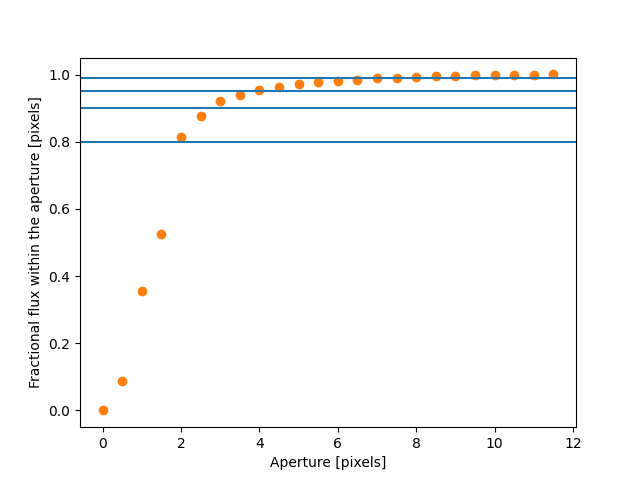

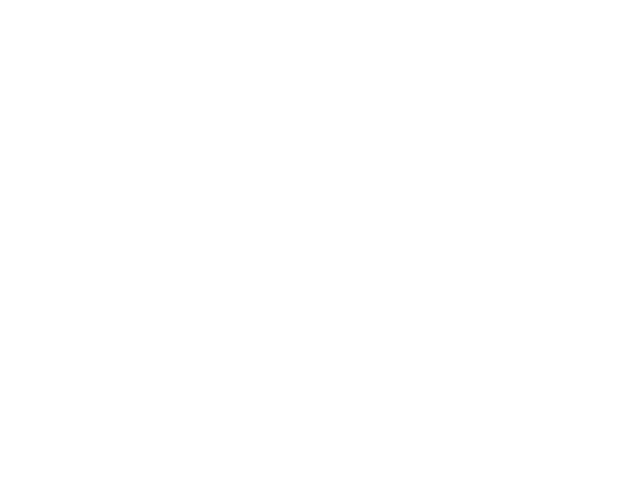

In [34]:
plt.figure()

inner_selection = (target_distance < inner_radius)
total_flux = np.sum(science_sky_corrected[inner_selection])

radius_array = np.arange(0, inner_radius+1., 0.5)
flux_vs_radius = np.zeros_like(radius_array)

for ii, aperture_radius in enumerate(radius_array):
    aperture_selection = (target_distance < aperture_radius)
    flux_vs_radius[ii] = np.sum(science_sky_corrected[aperture_selection])/total_flux
    print(ii, aperture_radius, flux_vs_radius[ii])


plt.scatter(radius_array, flux_vs_radius, c="C1")
plt.axhline(0.80)
plt.axhline(0.90)
plt.axhline(0.95)
plt.axhline(0.99)

plt.xlabel('Aperture [pixels]')
plt.ylabel('Fractional flux within the aperture [pixels]')
plt.figure()

In [35]:
aperture_01 = 6.0

aperture_02 = 8.0

aperture_03 = 10.0

#тут другие значения


aperture_selection = (target_distance < aperture_01)
aperture_photometry_01 = np.sum(science_sky_corrected[aperture_selection]) / total_flux

aperture_selection = (target_distance < aperture_02)
aperture_photometry_02 = np.sum(science_sky_corrected[aperture_selection]) / total_flux


aperture_selection = (target_distance < aperture_03)
aperture_photometry_03 = np.sum(science_sky_corrected[aperture_selection]) / total_flux

print('Fractional flux at aperture {0:2.1f} pixel: {1:3.3f}'.format(aperuterre))

NameError: name 'aperuterre' is not defined

In [ ]:
# Aperture photometry

aperture_selection = (target_distance < aperture_01)

In [ ]:
# error associated to sky background estimate (median -> average)
# error associated to the sky corrected pixel (it was difference)
# error associated to the aperture photometry (error)